In [1]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import wandb
import random
import math
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.cluster import KMeans

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

labels = data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Define compute metrics for evaluation
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [8]:
# Define compute metrics for evaluation
def compute_metrics_eval(p):
    result = compute_metrics(p)
    
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )    
    return {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_micro': result['f1_micro'],
        'f1_macro': result['f1_macro'],
        'report': report
    }

# ACTIVE LEARNING LOOP

In [9]:
accuracies = []
f1_micros = []
f1_macros = []
sampling_dur = []
data_used = []

In [10]:
filename = 'dat-kmeans'
epochs = 10
batch_size = 8
sequence_length = 256
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
import numpy as np
import torch
import time
from sklearn.cluster import KMeans

def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, trials, n_clusters=min_increment):
    start_time = time.time()
    current_train_size = len(train_indices)
    embeddings = []

    model.eval()  # Set the model to evaluation mode
    
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    collected_indices = set()  # Initialize set to store selected indices

    num_of_candidates = len(embeddings[:math.ceil(0.1 * len(embeddings))])

    # Check nearest checkpoint
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    # Determine number of clusters
    if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
        n_clusters = n_clusters
    elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
        n_clusters = num_of_candidates
    else:
        arrived_at_cp = True
        n_clusters = nearest_cp - current_train_size
        
    kmeans=KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)

    if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
        temp = train_indices.copy()
        temp.extend(collected_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            '1-FR': [y_train[i][0] for i in temp],
            '2-GI': [y_train[i][1] for i in temp],
            '3-PI': [y_train[i][2] for i in temp],
            '4-DM': [y_train[i][3] for i in temp],
            '5-EDTRB': [y_train[i][4] for i in temp],
            '6-RE': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        end_time = time.time()  # Record the end time
        duration = end_time - start_time  # Calculate the duration in seconds
        
        print("Nearest checkpoint:", nearest_cp)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(remaining_indices))
        print(f"Sampling duration: {duration} seconds")
        sampling_dur.append(duration)
        return remaining_indices
    else:
        # Get center of each cluster
        for cluster_id in range(n_clusters):
            # Cluster center and indices of samples in the current cluster
            cluster_center = kmeans.cluster_centers_[cluster_id]
            cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
            
            if cluster_indices.size == 0:
                # Skip clusters with no members
                print(f"Cluster {cluster_id} has no members, skipping.")
                continue
        
            # Calculate distances to the cluster center
            cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
            collected_indices.add(closest_sample_index)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend(collected_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            '1-FR': [y_train[i][0] for i in temp],
            '2-GI': [y_train[i][1] for i in temp],
            '3-PI': [y_train[i][2] for i in temp],
            '4-DM': [y_train[i][3] for i in temp],
            '5-EDTRB': [y_train[i][4] for i in temp],
            '6-RE': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print("Nearest checkpoint:", nearest_cp)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(collected_indices))
    print(f"Sampling duration: {duration} seconds")

    sampling_dur.append(duration)
    
    return [remaining_indices[i] for i in collected_indices]

In [12]:
def train_model(current_train_size, train_indices, trials, seed):
    model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p2',
        num_labels=len(labels),
        problem_type="multi_label_classification"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue
    
    # Create Dataset with current training data
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_dataset = DoctorAnswerDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{filename}-{trials+1}',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    trainer.compute_metrics = compute_metrics_eval
    eval_results = trainer.evaluate()
    print(f"Iteration {current_train_size}: Accuracy: {eval_results['eval_accuracy']}, F1 Micro: {eval_results['eval_f1_micro']}, F1 Macro: {eval_results['eval_f1_macro']}")
    print(eval_results['eval_report'])

    torch.save(model.state_dict(), f'{filename}-{trials+1}-model.pth')
    model.config.to_json_file(f'{filename}-{trials+1}-config.json')

    data_used.append(current_train_size)
    accuracies.append(eval_results['eval_accuracy'])
    f1_micros.append(eval_results['eval_f1_micro'])
    f1_macros.append(eval_results['eval_f1_macro'])
    
    return model, trainer

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [14]:
def active_learning(seed, i):
    accuracies.clear()
    f1_micros.clear()
    f1_macros.clear()
    sampling_dur.clear()
    data_used.clear()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model, trainer = train_model(current_train_size, train_indices, i, seed)
    
        # Perform query strategy to select new samples
        new_samples = kmeans_clustering_sampling(
            model, 
            [X_train[i] for i in remaining_indices], 
            train_indices,
            remaining_indices,
            tokenizer, 
            trials=i,
        )
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model, trainer = train_model(current_train_size, train_indices, i, seed)
    
    end_time = time.time()
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [15]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241231_081338-5welzoog
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/dat-kmeans-1
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.ai/nicost918-petra-christian-university/huggingface/runs/5welzoog


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.445599,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.302310,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.249813,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.216971,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.195783,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.184268,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.178531,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.174130,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.171843,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.170646,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.2074334621429443 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.286811,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.188148,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.160964,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.152417,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.148162,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.146535,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.144490,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.142727,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.142869,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.142996,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7519314289093018 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.207637,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.154218,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143064,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.139759,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.137660,0.800000,0.962406,0.979592,0.970923,0.652316
6,No log,0.138671,0.780000,0.964557,0.971939,0.968234,0.650175
7,No log,0.147799,0.760000,0.969152,0.961735,0.965429,0.647734
8,No log,0.138739,0.770000,0.964557,0.971939,0.968234,0.650175
9,No log,0.141869,0.780000,0.969309,0.966837,0.968072,0.649822
10,No log,0.140642,0.770000,0.966837,0.966837,0.966837,0.648975


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.4640517234802246 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.184721,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.146403,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.141729,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.137711,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.138584,0.800000,0.962406,0.979592,0.970923,0.652316
6,No log,0.140725,0.760000,0.964377,0.966837,0.965605,0.648138
7,No log,0.143028,0.760000,0.966752,0.964286,0.965517,0.647938
8,No log,0.140906,0.770000,0.964557,0.971939,0.968234,0.650175
9,No log,0.141651,0.770000,0.966837,0.966837,0.966837,0.648975
10,No log,0.141447,0.770000,0.966837,0.966837,0.966837,0.648975


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.374422788619995 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.166065,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140181,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.137334,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.134046,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.141437,0.770000,0.969231,0.964286,0.966752,0.648784
6,No log,0.138386,0.790000,0.969388,0.969388,0.969388,0.650848
7,No log,0.144074,0.770000,0.969231,0.964286,0.966752,0.648784
8,No log,0.139447,0.780000,0.969388,0.969388,0.969388,0.650848
9,No log,0.138298,0.790000,0.969466,0.971939,0.970701,0.651863
10,No log,0.140077,0.790000,0.969466,0.971939,0.970701,0.651863


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.0798208713531494 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.163650,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139479,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.147685,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.133823,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.134833,0.780000,0.964557,0.971939,0.968234,0.650175
6,No log,0.133541,0.790000,0.969388,0.969388,0.969388,0.650848
7,No log,0.138819,0.770000,0.971649,0.961735,0.966667,0.648588
8,No log,0.135627,0.800000,0.969543,0.974490,0.972010,0.652866
9,No log,0.137070,0.790000,0.971795,0.966837,0.969309,0.650678
10,No log,0.135856,0.790000,0.971795,0.966837,0.969309,0.650678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.8940439224243164 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.159543,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140732,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135235,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136564,0.780000,0.967005,0.971939,0.969466,0.651014
5,No log,0.134551,0.780000,0.969309,0.966837,0.968072,0.649822
6,No log,0.137280,0.770000,0.971649,0.961735,0.966667,0.648588
7,No log,0.134724,0.790000,0.971867,0.969388,0.970626,0.651705
8,No log,0.136292,0.820000,0.969697,0.979592,0.974619,0.654840
9,No log,0.130130,0.790000,0.971867,0.969388,0.970626,0.651705
10,No log,0.130337,0.790000,0.971867,0.969388,0.970626,0.651705


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.82, F1 Micro: 0.9746192893401016, F1 Macro: 0.6548401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7618167400360107 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149900,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136190,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128394,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.127968,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.125250,0.830000,0.972152,0.979592,0.975858,0.655700
6,No log,0.123485,0.810000,0.972010,0.974490,0.973248,0.653725
7,No log,0.122004,0.800000,0.971939,0.971939,0.971939,0.652721
8,No log,0.124558,0.820000,0.972081,0.977041,0.974555,0.654718
9,No log,0.123001,0.800000,0.971939,0.971939,0.971939,0.652721
10,No log,0.124035,0.800000,0.971939,0.971939,0.971939,0.652721


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.6166608333587646 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150125,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139543,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130271,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.122790,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.118163,0.820000,0.972081,0.977041,0.974555,0.654718
6,No log,0.121663,0.820000,0.972081,0.977041,0.974555,0.654718
7,No log,0.115844,0.820000,0.972081,0.977041,0.974555,0.654718
8,No log,0.117740,0.820000,0.969620,0.977041,0.973316,0.654718
9,No log,0.117672,0.830000,0.969697,0.979592,0.974619,0.710274
10,No log,0.120209,0.840000,0.969773,0.982143,0.975919,0.749956


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.75      0.75       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.84, F1 Micro: 0.9759188846641319, F1 Macro: 0.7499561298556273
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.75      0.75       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.5422556400299072 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149454,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.144213,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129947,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.125645,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.130423,0.760000,0.976501,0.954082,0.965161,0.647091
6,No log,0.117549,0.810000,0.972010,0.974490,0.973248,0.653725
7,No log,0.116034,0.810000,0.972010,0.974490,0.973248,0.653725
8,No log,0.115773,0.820000,0.972081,0.977041,0.974555,0.720392
9,No log,0.116712,0.810000,0.972010,0.974490,0.973248,0.719387
10,No log,0.116909,0.820000,0.972081,0.977041,0.974555,0.720392


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.81      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.82, F1 Micro: 0.9745547073791349, F1 Macro: 0.7203915293413061
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.81      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4754869937896729 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146468,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139182,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132164,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.127864,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.121614,0.800000,0.976744,0.964286,0.970475,0.651378
6,No log,0.125276,0.840000,0.969773,0.982143,0.975919,0.721507
7,No log,0.117707,0.810000,0.969543,0.974490,0.972010,0.708276
8,No log,0.117205,0.830000,0.969697,0.979592,0.974619,0.710274
9,No log,0.118416,0.830000,0.969697,0.979592,0.974619,0.710274
10,No log,0.118087,0.840000,0.969773,0.982143,0.975919,0.749956


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.84, F1 Micro: 0.9759188846641319, F1 Macro: 0.7215068014062989
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.3594889640808105 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147393,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137312,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131421,0.800000,0.962406,0.979592,0.970923,0.652316
4,No log,0.141510,0.810000,0.974359,0.969388,0.971867,0.652572
5,No log,0.152745,0.720000,0.983957,0.938776,0.960836,0.642912
6,No log,0.124480,0.820000,0.974425,0.971939,0.973180,0.653588
7,No log,0.119455,0.830000,0.974490,0.974490,0.974490,0.720255
8,No log,0.123472,0.830000,0.967337,0.982143,0.974684,0.710396
9,No log,0.123135,0.820000,0.972010,0.974490,0.973248,0.709144
10,No log,0.123329,0.820000,0.969697,0.979592,0.974619,0.710274


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.25      0.33         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.73      0.71      0.71       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.7103956902951878
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.25      0.33         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.73      0.71      0.71       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.2422704696655273 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149300,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138438,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132073,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.134608,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.128413,0.820000,0.971939,0.971939,0.971939,0.652721
6,No log,0.126743,0.800000,0.974293,0.966837,0.970551,0.717170
7,No log,0.121003,0.820000,0.976923,0.971939,0.974425,0.720115
8,No log,0.130179,0.820000,0.962594,0.984694,0.973518,0.722367
9,No log,0.122329,0.830000,0.972152,0.979592,0.975858,0.721385
10,No log,0.122897,0.840000,0.972152,0.979592,0.975858,0.711143


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.7213847012841987
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.2809853553771973 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144727,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132503,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125898,0.810000,0.964912,0.982143,0.973451,0.654117
4,No log,0.123080,0.830000,0.974555,0.977041,0.975796,0.655587
5,No log,0.114401,0.820000,0.974425,0.971939,0.973180,0.653588
6,No log,0.114094,0.840000,0.979487,0.974490,0.976982,0.765446
7,No log,0.115453,0.840000,0.969773,0.982143,0.975919,0.749956
8,No log,0.120813,0.850000,0.967419,0.984694,0.975980,0.755587
9,No log,0.120349,0.860000,0.967500,0.987245,0.977273,0.766811
10,No log,0.117019,0.850000,0.967419,0.984694,0.975980,0.739034


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9772727272727273, F1 Macro: 0.7668113433959237
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.1399588584899902 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144904,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135311,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125909,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.113875,0.830000,0.974490,0.974490,0.974490,0.654593
5,No log,0.115185,0.830000,0.972010,0.974490,0.973248,0.709144
6,No log,0.116998,0.850000,0.967337,0.982143,0.974684,0.754593
7,No log,0.113175,0.840000,0.969697,0.979592,0.974619,0.748963
8,No log,0.114833,0.840000,0.969773,0.982143,0.975919,0.749956
9,No log,0.115546,0.850000,0.969849,0.984694,0.977215,0.779718
10,No log,0.115474,0.850000,0.969773,0.982143,0.975919,0.778725


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.85, F1 Micro: 0.9772151898734177, F1 Macro: 0.779718034617532
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.1574339866638184 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144438,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135994,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131280,0.800000,0.962406,0.979592,0.970923,0.652316
4,No log,0.119966,0.800000,0.974293,0.966837,0.970551,0.651543
5,No log,0.120919,0.810000,0.974359,0.969388,0.971867,0.652572
6,No log,0.117380,0.830000,0.972152,0.979592,0.975858,0.721385
7,No log,0.115652,0.830000,0.972152,0.979592,0.975858,0.721385
8,No log,0.117041,0.830000,0.972152,0.979592,0.975858,0.721385
9,No log,0.121650,0.850000,0.965087,0.987245,0.976040,0.755700
10,No log,0.118811,0.830000,0.967337,0.982143,0.974684,0.738051


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.85, F1 Micro: 0.9760403530895334, F1 Macro: 0.7557002322848126
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 1.006164312362671 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144466,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143851,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123108,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.120641,0.830000,0.969773,0.982143,0.975919,0.655811
5,No log,0.111858,0.810000,0.974490,0.974490,0.974490,0.720255
6,No log,0.113572,0.790000,0.974359,0.969388,0.971867,0.718210
7,No log,0.111667,0.840000,0.969773,0.982143,0.975919,0.749956
8,No log,0.113425,0.850000,0.969849,0.984694,0.977215,0.779718
9,No log,0.113037,0.850000,0.972292,0.984694,0.978454,0.780587
10,No log,0.113008,0.850000,0.972292,0.984694,0.978454,0.780587


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.9367005825042725 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142121,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133112,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119068,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.117660,0.820000,0.972081,0.977041,0.974555,0.654718
5,No log,0.123399,0.830000,0.972152,0.979592,0.975858,0.721385
6,No log,0.118849,0.850000,0.972081,0.977041,0.974555,0.737799
7,No log,0.120557,0.840000,0.967337,0.982143,0.974684,0.738051
8,No log,0.117681,0.830000,0.972152,0.979592,0.975858,0.721385
9,No log,0.122805,0.820000,0.971867,0.969388,0.970626,0.734712
10,No log,0.118924,0.840000,0.969697,0.979592,0.974619,0.703206


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.7213847012841987
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.888843297958374 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139487,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132599,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124355,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.124768,0.800000,0.981771,0.961735,0.971649,0.652104
5,No log,0.114014,0.830000,0.974490,0.974490,0.974490,0.720255
6,No log,0.121184,0.800000,0.971795,0.966837,0.969309,0.744690
7,No log,0.117274,0.860000,0.972222,0.982143,0.977157,0.779593
8,No log,0.117036,0.800000,0.971795,0.966837,0.969309,0.706059
9,No log,0.115855,0.810000,0.976804,0.966837,0.971795,0.718045
10,No log,0.118822,0.860000,0.967419,0.984694,0.975980,0.755587


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.86, F1 Micro: 0.9771573604060914, F1 Macro: 0.7795931906724634
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.8328056335449219 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148383,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134551,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.120880,0.820000,0.974425,0.971939,0.973180,0.653588
4,No log,0.116678,0.840000,0.972081,0.977041,0.974555,0.703090
5,No log,0.113182,0.830000,0.976923,0.971939,0.974425,0.720115
6,No log,0.112797,0.820000,0.979381,0.969388,0.974359,0.719972
7,No log,0.115256,0.850000,0.977099,0.979592,0.978344,0.751598
8,No log,0.114870,0.840000,0.972222,0.982143,0.977157,0.750825
9,No log,0.114403,0.850000,0.977099,0.979592,0.978344,0.751598
10,No log,0.114209,0.840000,0.972222,0.982143,0.977157,0.750825


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.7515975439970415
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6789758205413818 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148909,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138391,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116388,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.111227,0.810000,0.974359,0.969388,0.971867,0.652572
5,No log,0.111564,0.850000,0.972152,0.979592,0.975858,0.765577
6,No log,0.111757,0.850000,0.969773,0.982143,0.975919,0.765704
7,No log,0.109237,0.860000,0.974684,0.982143,0.978399,0.780471
8,No log,0.108357,0.860000,0.972292,0.984694,0.978454,0.780587
9,No log,0.111383,0.850000,0.967337,0.982143,0.974684,0.754593
10,No log,0.108556,0.860000,0.972222,0.982143,0.977157,0.779593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5715487003326416 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138632,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130362,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119029,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.110594,0.830000,0.974555,0.977041,0.975796,0.655587
5,No log,0.115560,0.830000,0.972010,0.974490,0.973248,0.763530
6,No log,0.107187,0.840000,0.972152,0.979592,0.975858,0.778588
7,No log,0.115126,0.820000,0.969543,0.974490,0.972010,0.752419
8,No log,0.108328,0.830000,0.967254,0.979592,0.973384,0.753588
9,No log,0.111427,0.830000,0.967254,0.979592,0.973384,0.753588
10,No log,0.109764,0.830000,0.967337,0.982143,0.974684,0.754593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.84, F1 Micro: 0.9758576874205843, F1 Macro: 0.7785880911147073
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.47809624671936035 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140606,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132244,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122098,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.112959,0.840000,0.974619,0.979592,0.977099,0.722254
5,No log,0.107454,0.840000,0.976982,0.974490,0.975734,0.795276
6,No log,0.107569,0.840000,0.976982,0.974490,0.975734,0.795276
7,No log,0.107687,0.850000,0.972292,0.984694,0.978454,0.767577
8,No log,0.109893,0.840000,0.972222,0.982143,0.977157,0.766582
9,No log,0.110171,0.860000,0.972362,0.987245,0.979747,0.768560
10,No log,0.108996,0.840000,0.972222,0.982143,0.977157,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.4711942672729492 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142903,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137239,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115248,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.116317,0.840000,0.969773,0.982143,0.975919,0.655811
5,No log,0.111253,0.780000,0.974093,0.959184,0.966581,0.742330
6,No log,0.108122,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.107742,0.820000,0.976923,0.971939,0.974425,0.763530
8,No log,0.107572,0.840000,0.974555,0.977041,0.975796,0.778448
9,No log,0.108644,0.840000,0.974555,0.977041,0.975796,0.778448
10,0.109800,0.106868,0.840000,0.974555,0.977041,0.975796,0.778448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.7794655093650068
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392

Total sampling time: 33.21 seconds
Total runtime: 2705.3968665599823 seconds


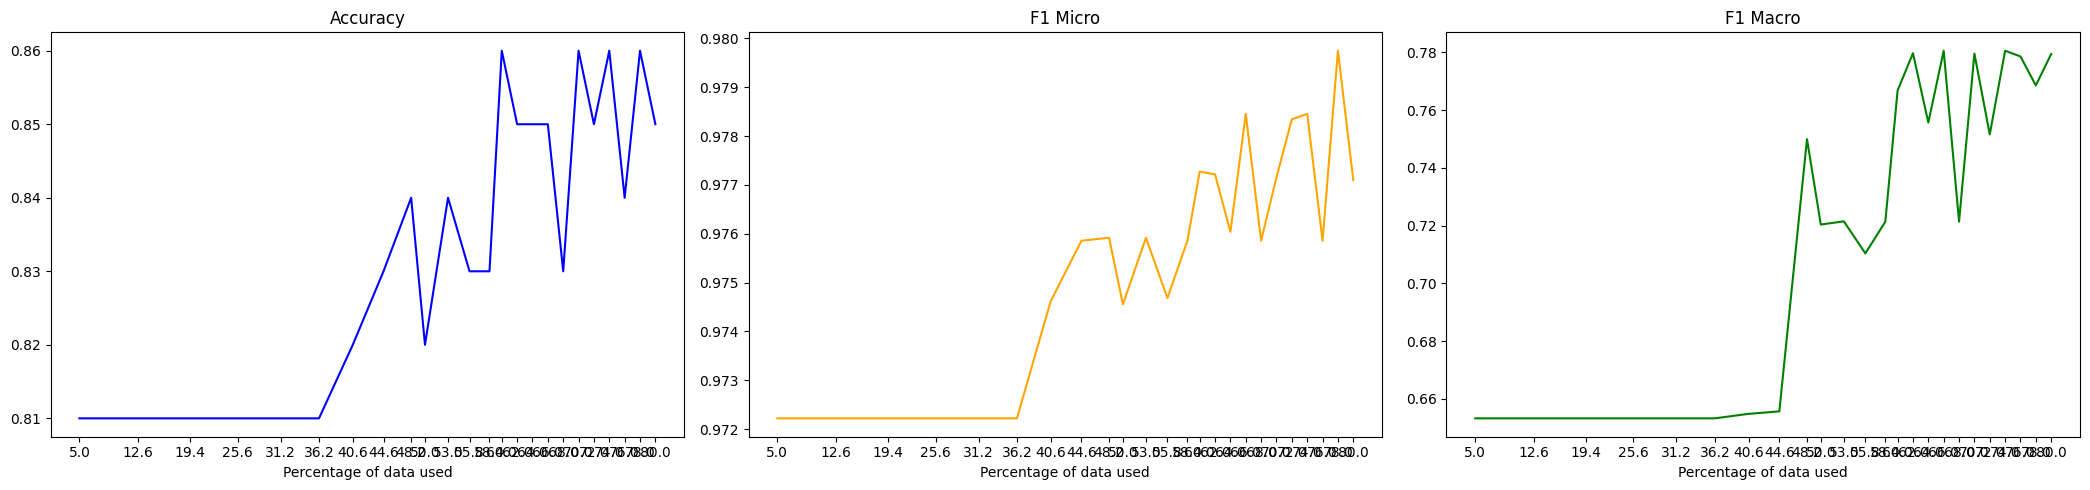

In [16]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.427260,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.301268,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.235869,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.204235,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.186607,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.177279,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.172513,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.168742,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.166898,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.166246,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.1460678577423096 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251911,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.177669,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.161853,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.152647,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.146645,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.143207,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.140890,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.141181,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.139872,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.139839,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.84989333152771 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.192399,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.152671,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143366,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.138173,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.134596,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.135351,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.130653,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.128747,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.128048,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.127735,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.5917654037475586 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.172880,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145326,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.139310,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.132482,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.128341,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.125794,0.820000,0.964912,0.982143,0.973451,0.654117
7,No log,0.125341,0.830000,0.967337,0.982143,0.974684,0.654960
8,No log,0.123251,0.830000,0.969697,0.979592,0.974619,0.654840
9,No log,0.121630,0.830000,0.969697,0.979592,0.974619,0.654840
10,No log,0.121819,0.830000,0.969697,0.979592,0.974619,0.654840


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.3503494262695312 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.158555,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140147,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132735,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.135604,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.126399,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.127885,0.810000,0.967172,0.977041,0.972081,0.653009
7,No log,0.130933,0.830000,0.967337,0.982143,0.974684,0.654960
8,No log,0.127257,0.820000,0.967254,0.979592,0.973384,0.653989
9,No log,0.127086,0.790000,0.969388,0.969388,0.969388,0.650848
10,No log,0.125942,0.810000,0.969543,0.974490,0.972010,0.652866


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.1816229820251465 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.156245,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137689,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130863,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.132080,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.122641,0.820000,0.967254,0.979592,0.973384,0.653989
6,No log,0.119645,0.830000,0.969697,0.979592,0.974619,0.654840
7,No log,0.115858,0.830000,0.969697,0.979592,0.974619,0.654840
8,No log,0.116339,0.830000,0.972152,0.979592,0.975858,0.655700
9,No log,0.116595,0.820000,0.974490,0.974490,0.974490,0.654593
10,No log,0.116310,0.820000,0.974490,0.974490,0.974490,0.654593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.9536538124084473 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155281,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136029,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130740,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123179,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.119746,0.830000,0.972081,0.977041,0.974555,0.654718
6,No log,0.118538,0.840000,0.972152,0.979592,0.975858,0.655700
7,No log,0.120534,0.830000,0.969697,0.979592,0.974619,0.654840
8,No log,0.116331,0.840000,0.972152,0.979592,0.975858,0.655700
9,No log,0.117993,0.840000,0.972152,0.979592,0.975858,0.655700
10,No log,0.117816,0.840000,0.972152,0.979592,0.975858,0.655700


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.84, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.8724029064178467 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150177,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136761,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131319,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.130700,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.124725,0.810000,0.976923,0.971939,0.974425,0.654466
6,No log,0.137023,0.750000,0.976562,0.956633,0.966495,0.648182
7,No log,0.123040,0.820000,0.976982,0.974490,0.975734,0.655471
8,No log,0.124164,0.810000,0.974425,0.971939,0.973180,0.653588
9,No log,0.122949,0.810000,0.974425,0.971939,0.973180,0.653588
10,No log,0.121468,0.820000,0.974490,0.974490,0.974490,0.654593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.97      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.97      0.97       392
 samples avg       0.98      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.82, F1 Micro: 0.9757343550446999, F1 Macro: 0.6554713302860821
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.97      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.97      0.97       392
 samples avg       0.98      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.655503273010254 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147358,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132529,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130599,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.114392,0.830000,0.969697,0.979592,0.974619,0.654840
5,No log,0.117394,0.820000,0.972081,0.977041,0.974555,0.654718
6,No log,0.112454,0.820000,0.974490,0.974490,0.974490,0.654593
7,No log,0.111632,0.810000,0.974490,0.974490,0.974490,0.654593
8,No log,0.112010,0.820000,0.972081,0.977041,0.974555,0.654718
9,No log,0.112392,0.810000,0.974490,0.974490,0.974490,0.654593
10,No log,0.112098,0.810000,0.974490,0.974490,0.974490,0.654593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.83, F1 Micro: 0.9746192893401016, F1 Macro: 0.6548401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.6299324035644531 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145668,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135208,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127142,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.121807,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.113418,0.820000,0.972081,0.977041,0.974555,0.654718
6,No log,0.117233,0.820000,0.976982,0.974490,0.975734,0.655471
7,No log,0.116060,0.820000,0.972081,0.977041,0.974555,0.654718
8,No log,0.115244,0.790000,0.979275,0.964286,0.971722,0.717876
9,No log,0.110555,0.820000,0.974555,0.977041,0.975796,0.721260
10,No log,0.110269,0.830000,0.974619,0.979592,0.977099,0.722254


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.83, F1 Micro: 0.9770992366412214, F1 Macro: 0.7222537267342298
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.532578468322754 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148518,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133792,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130013,0.820000,0.967254,0.979592,0.973384,0.653989
4,No log,0.116888,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.117187,0.830000,0.974555,0.977041,0.975796,0.721260
6,No log,0.118264,0.820000,0.979434,0.971939,0.975672,0.721002
7,No log,0.109304,0.840000,0.972222,0.982143,0.977157,0.765829
8,No log,0.106664,0.830000,0.972152,0.979592,0.975858,0.764836
9,No log,0.107924,0.850000,0.972292,0.984694,0.978454,0.797575
10,No log,0.107593,0.850000,0.972292,0.984694,0.978454,0.797575


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.797575177474675
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.3356409072875977 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144304,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142790,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126227,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.112544,0.840000,0.969773,0.982143,0.975919,0.655811
5,No log,0.110766,0.800000,0.974425,0.971939,0.973180,0.653588
6,No log,0.110069,0.840000,0.972222,0.982143,0.977157,0.656672
7,No log,0.107352,0.830000,0.974619,0.979592,0.977099,0.722254
8,No log,0.107551,0.830000,0.974619,0.979592,0.977099,0.765704
9,No log,0.106977,0.850000,0.974747,0.984694,0.979695,0.798444
10,No log,0.107651,0.850000,0.974747,0.984694,0.979695,0.798444


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.85, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.2855393886566162 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142200,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136698,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128542,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.113817,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.109195,0.820000,0.976982,0.974490,0.975734,0.655471
6,No log,0.103928,0.840000,0.974684,0.982143,0.978399,0.723237
7,No log,0.112084,0.870000,0.970000,0.989796,0.979798,0.798668
8,No log,0.101551,0.860000,0.974811,0.987245,0.980989,0.799427
9,No log,0.103150,0.850000,0.974747,0.984694,0.979695,0.798444
10,No log,0.104125,0.860000,0.974811,0.987245,0.980989,0.799427


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.86, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.3237297534942627 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145630,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133478,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125967,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.111168,0.820000,0.972081,0.977041,0.974555,0.654718
5,No log,0.106987,0.810000,0.974490,0.974490,0.974490,0.654593
6,No log,0.103198,0.830000,0.974619,0.979592,0.977099,0.722254
7,No log,0.104884,0.850000,0.972292,0.984694,0.978454,0.766811
8,No log,0.102919,0.850000,0.974747,0.984694,0.979695,0.798444
9,No log,0.103669,0.830000,0.972222,0.982143,0.977157,0.779593
10,No log,0.105010,0.840000,0.972292,0.984694,0.978454,0.780587


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.85, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.160315990447998 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143994,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133057,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124154,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.114408,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.111174,0.830000,0.969697,0.979592,0.974619,0.654840
6,No log,0.107890,0.810000,0.974490,0.974490,0.974490,0.720255
7,No log,0.103886,0.830000,0.974619,0.979592,0.977099,0.722254
8,No log,0.105864,0.830000,0.972222,0.982143,0.977157,0.779593
9,No log,0.105005,0.830000,0.969773,0.982143,0.975919,0.749956
10,No log,0.105201,0.840000,0.972292,0.984694,0.978454,0.780587


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.84, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.074897289276123 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140927,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145647,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124311,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.111420,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.116087,0.840000,0.972222,0.982143,0.977157,0.656672
6,No log,0.108088,0.830000,0.972152,0.979592,0.975858,0.655700
7,No log,0.108476,0.810000,0.974490,0.974490,0.974490,0.654593
8,No log,0.106554,0.840000,0.972292,0.984694,0.978454,0.780587
9,No log,0.106991,0.840000,0.972292,0.984694,0.978454,0.780587
10,No log,0.106757,0.840000,0.972292,0.984694,0.978454,0.780587


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.84, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 1.0608627796173096 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140322,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133229,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119898,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.108859,0.840000,0.972222,0.982143,0.977157,0.656672
5,No log,0.106984,0.830000,0.972152,0.979592,0.975858,0.655700
6,No log,0.114417,0.830000,0.972081,0.977041,0.974555,0.764559
7,No log,0.108944,0.820000,0.972081,0.977041,0.974555,0.703090
8,No log,0.108760,0.830000,0.967337,0.982143,0.974684,0.764836
9,No log,0.107192,0.830000,0.972152,0.979592,0.975858,0.738805
10,No log,0.107077,0.820000,0.967254,0.979592,0.973384,0.737058


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.9318366050720215 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138565,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128936,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121518,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.113970,0.820000,0.972081,0.977041,0.974555,0.654718
5,No log,0.110437,0.820000,0.979434,0.971939,0.975672,0.655353
6,No log,0.107005,0.820000,0.976982,0.974490,0.975734,0.655471
7,No log,0.109239,0.810000,0.979381,0.969388,0.974359,0.654335
8,No log,0.106383,0.840000,0.974684,0.982143,0.978399,0.766698
9,No log,0.105976,0.840000,0.974684,0.982143,0.978399,0.766698
10,No log,0.105760,0.840000,0.974684,0.982143,0.978399,0.766698


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.84, F1 Micro: 0.9783989834815755, F1 Macro: 0.7666981711786742
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.9939990043640137 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139649,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130554,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.114571,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.113186,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.114485,0.810000,0.979381,0.969388,0.974359,0.654335
6,No log,0.111417,0.830000,0.972152,0.979592,0.975858,0.655700
7,No log,0.106944,0.830000,0.977041,0.977041,0.977041,0.796305
8,No log,0.102026,0.850000,0.974747,0.984694,0.979695,0.798444
9,No log,0.102408,0.850000,0.977157,0.982143,0.979644,0.798328
10,No log,0.102330,0.850000,0.974747,0.984694,0.979695,0.798444


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.85, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7899231910705566 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138722,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134234,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119597,0.840000,0.974619,0.979592,0.977099,0.656570
4,No log,0.109422,0.800000,0.976804,0.966837,0.971795,0.652419
5,No log,0.108997,0.820000,0.972081,0.977041,0.974555,0.654718
6,No log,0.110777,0.840000,0.967419,0.984694,0.975980,0.765829
7,No log,0.108286,0.840000,0.967419,0.984694,0.975980,0.765829
8,No log,0.105018,0.850000,0.972292,0.984694,0.978454,0.767577
9,No log,0.106976,0.840000,0.967419,0.984694,0.975980,0.765829
10,No log,0.105139,0.840000,0.967419,0.984694,0.975980,0.765829


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7675769609596045
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.7918858528137207 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.137609,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128456,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119317,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.109288,0.820000,0.974490,0.974490,0.974490,0.654593
5,No log,0.115851,0.820000,0.974359,0.969388,0.971867,0.762320
6,No log,0.106651,0.850000,0.974619,0.979592,0.977099,0.765704
7,No log,0.107731,0.860000,0.972222,0.982143,0.977157,0.779593
8,No log,0.104631,0.870000,0.972292,0.984694,0.978454,0.780587
9,No log,0.105301,0.830000,0.972010,0.974490,0.973248,0.776543
10,No log,0.104799,0.870000,0.972362,0.987245,0.979747,0.781570


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.87, F1 Micro: 0.979746835443038, F1 Macro: 0.781569886469384
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.57916259765625 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140589,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132915,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129801,0.800000,0.974293,0.966837,0.970551,0.651543
4,No log,0.107919,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.104502,0.790000,0.979275,0.964286,0.971722,0.652263
6,No log,0.105393,0.820000,0.976923,0.971939,0.974425,0.777263
7,No log,0.106521,0.830000,0.974555,0.977041,0.975796,0.764699
8,No log,0.105727,0.840000,0.969773,0.982143,0.975919,0.765704
9,No log,0.107075,0.840000,0.969773,0.982143,0.975919,0.765704
10,No log,0.105050,0.850000,0.972222,0.982143,0.977157,0.779593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9771573604060914, F1 Macro: 0.7795931906724634
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.4760720729827881 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140274,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130418,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122750,0.790000,0.976684,0.961735,0.969152,0.650325
4,No log,0.109798,0.810000,0.972010,0.974490,0.973248,0.653725
5,No log,0.106064,0.840000,0.974619,0.979592,0.977099,0.796445
6,No log,0.109689,0.830000,0.976982,0.974490,0.975734,0.778305
7,No log,0.113579,0.810000,0.974359,0.969388,0.971867,0.762320
8,No log,0.107292,0.830000,0.972081,0.977041,0.974555,0.764559
9,No log,0.107424,0.840000,0.974555,0.977041,0.975796,0.778448
10,No log,0.105964,0.850000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.7964452339718501
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.5253660678863525 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142727,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129936,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118973,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.110243,0.840000,0.969773,0.982143,0.975919,0.721507
5,No log,0.105247,0.830000,0.974555,0.977041,0.975796,0.721260
6,No log,0.106003,0.850000,0.969849,0.984694,0.977215,0.779718
7,No log,0.102018,0.830000,0.974555,0.977041,0.975796,0.778448
8,No log,0.101552,0.840000,0.977041,0.977041,0.977041,0.796305
9,No log,0.101871,0.830000,0.972081,0.977041,0.974555,0.764559
10,0.102300,0.102163,0.840000,0.969773,0.982143,0.975919,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.9772151898734177, F1 Macro: 0.779718034617532
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 34.09 seconds
Total runtime: 2598.9942302703857 seconds


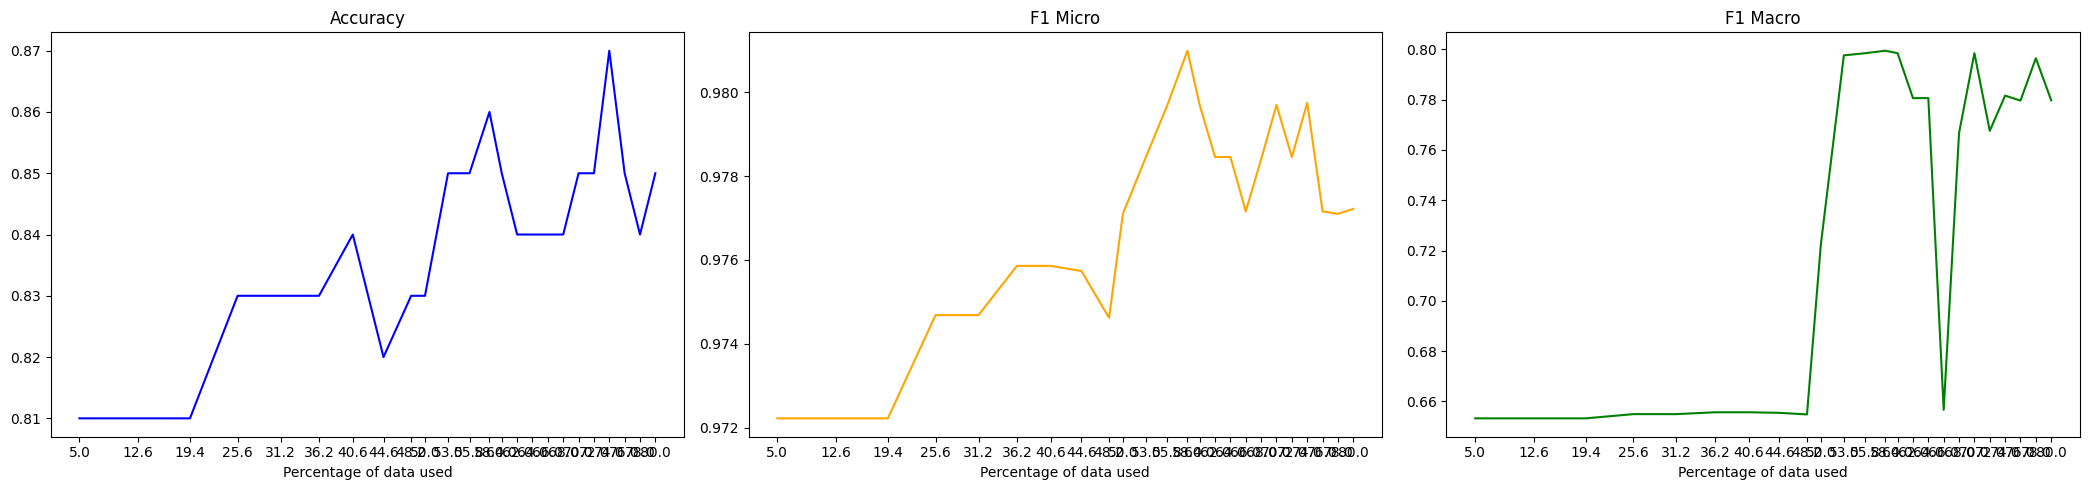

In [17]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.397611,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.288708,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.231498,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.205215,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.187409,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.178176,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.173865,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.169992,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.167555,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.166610,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.1373918056488037 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.270307,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.188848,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.162789,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.151579,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.146378,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.144114,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.141597,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.140537,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.140068,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.139845,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.8151683807373047 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.195829,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.156736,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.145194,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.140699,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.141375,0.780000,0.962217,0.974490,0.968314,0.650346
6,No log,0.137467,0.780000,0.962217,0.974490,0.968314,0.650346
7,No log,0.139998,0.780000,0.966921,0.969388,0.968153,0.650000
8,No log,0.139712,0.780000,0.966921,0.969388,0.968153,0.650000
9,No log,0.142575,0.760000,0.969152,0.961735,0.965429,0.647734
10,No log,0.144865,0.740000,0.971429,0.954082,0.962677,0.645361


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.638803005218506 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.182037,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.149592,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.139480,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136690,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.138623,0.790000,0.969388,0.969388,0.969388,0.650848
6,No log,0.131768,0.800000,0.969466,0.971939,0.970701,0.651863
7,No log,0.131182,0.820000,0.974425,0.971939,0.973180,0.653588
8,No log,0.133539,0.820000,0.979328,0.966837,0.973042,0.653305
9,No log,0.131765,0.810000,0.974359,0.969388,0.971867,0.652572
10,No log,0.133856,0.800000,0.974293,0.966837,0.970551,0.651543


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.96       392
 samples avg       0.97      0.97      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.82, F1 Micro: 0.9731800766283526, F1 Macro: 0.6535880911147073
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.96       392
 samples avg       0.97      0.97      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.42063570022583 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.166440,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141294,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135455,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.133965,0.780000,0.964557,0.971939,0.968234,0.650175
5,No log,0.131468,0.800000,0.969466,0.971939,0.970701,0.651863
6,No log,0.134995,0.780000,0.974160,0.961735,0.967908,0.649451
7,No log,0.132168,0.810000,0.971867,0.969388,0.970626,0.651705
8,No log,0.132860,0.790000,0.974227,0.964286,0.969231,0.650503
9,No log,0.134097,0.790000,0.974227,0.964286,0.969231,0.650503
10,No log,0.134393,0.790000,0.974227,0.964286,0.969231,0.650503


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.205929756164551 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.158988,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141418,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132058,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.131355,0.800000,0.971867,0.969388,0.970626,0.651705
5,No log,0.127838,0.800000,0.971867,0.969388,0.970626,0.651705
6,No log,0.129452,0.790000,0.974227,0.964286,0.969231,0.650503
7,No log,0.130049,0.790000,0.974227,0.964286,0.969231,0.650503
8,No log,0.128618,0.810000,0.974359,0.969388,0.971867,0.652572
9,No log,0.126824,0.820000,0.974425,0.971939,0.973180,0.653588
10,No log,0.128456,0.810000,0.974359,0.969388,0.971867,0.652572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.96       392
 samples avg       0.97      0.97      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.82, F1 Micro: 0.9731800766283526, F1 Macro: 0.6535880911147073
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.96       392
 samples avg       0.97      0.97      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.9823493957519531 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153136,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136469,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138700,0.790000,0.971795,0.966837,0.969309,0.650678
4,No log,0.127201,0.800000,0.964824,0.979592,0.972152,0.653148
5,No log,0.132822,0.770000,0.971649,0.961735,0.966667,0.648588
6,No log,0.127864,0.790000,0.971795,0.966837,0.969309,0.650678
7,No log,0.133390,0.770000,0.976562,0.956633,0.966495,0.648182
8,No log,0.124630,0.810000,0.972010,0.974490,0.973248,0.653725
9,No log,0.124920,0.810000,0.974359,0.969388,0.971867,0.652572
10,No log,0.124138,0.810000,0.974359,0.969388,0.971867,0.652572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.96       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.81, F1 Micro: 0.9732484076433121, F1 Macro: 0.6537248626746396
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.96       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.8683390617370605 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151936,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134158,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124751,0.830000,0.969773,0.982143,0.975919,0.655811
4,No log,0.120089,0.820000,0.972010,0.974490,0.973248,0.653725
5,No log,0.121023,0.790000,0.974227,0.964286,0.969231,0.650503
6,No log,0.123471,0.810000,0.974359,0.969388,0.971867,0.652572
7,No log,0.119369,0.790000,0.974227,0.964286,0.969231,0.650503
8,No log,0.120474,0.800000,0.974293,0.966837,0.970551,0.651543
9,No log,0.117513,0.810000,0.974359,0.969388,0.971867,0.652572
10,No log,0.118413,0.800000,0.974293,0.966837,0.970551,0.651543


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.83, F1 Micro: 0.9759188846641319, F1 Macro: 0.6558109307923955
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.7153737545013428 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148439,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134107,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123093,0.820000,0.967337,0.982143,0.974684,0.654960
4,No log,0.121867,0.810000,0.974359,0.969388,0.971867,0.652572
5,No log,0.117332,0.810000,0.971939,0.971939,0.971939,0.652721
6,No log,0.114156,0.810000,0.974359,0.969388,0.971867,0.652572
7,No log,0.109395,0.820000,0.972010,0.974490,0.973248,0.653725
8,No log,0.109938,0.850000,0.974619,0.979592,0.977099,0.765704
9,No log,0.105832,0.820000,0.974425,0.971939,0.973180,0.762655
10,No log,0.107017,0.830000,0.972010,0.974490,0.973248,0.747810


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.7657043017835745
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.6506505012512207 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146597,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133606,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123277,0.820000,0.969697,0.979592,0.974619,0.654840
4,No log,0.123865,0.800000,0.974293,0.966837,0.970551,0.651543
5,No log,0.123861,0.830000,0.974490,0.974490,0.974490,0.654593
6,No log,0.119379,0.810000,0.974359,0.969388,0.971867,0.652572
7,No log,0.117515,0.810000,0.976804,0.966837,0.971795,0.718045
8,No log,0.112213,0.830000,0.974490,0.974490,0.974490,0.720255
9,No log,0.109603,0.820000,0.974425,0.971939,0.973180,0.719238
10,No log,0.110264,0.830000,0.974490,0.974490,0.974490,0.763683


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.82, F1 Micro: 0.9746192893401016, F1 Macro: 0.6548401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.5045480728149414 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147307,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134032,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129313,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.120460,0.830000,0.972081,0.977041,0.974555,0.654718
5,No log,0.116309,0.840000,0.974555,0.977041,0.975796,0.655587
6,No log,0.109788,0.830000,0.974490,0.974490,0.974490,0.654593
7,No log,0.109194,0.820000,0.974425,0.971939,0.973180,0.719238
8,No log,0.111225,0.820000,0.971939,0.971939,0.971939,0.735753
9,No log,0.105739,0.840000,0.974555,0.977041,0.975796,0.721260
10,No log,0.107867,0.840000,0.972152,0.979592,0.975858,0.749831


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.84, F1 Micro: 0.9758576874205843, F1 Macro: 0.7498312859105587
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.434180498123169 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145597,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132565,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119602,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.117283,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.110012,0.830000,0.972152,0.979592,0.975858,0.655700
6,No log,0.104390,0.850000,0.974619,0.979592,0.977099,0.765704
7,No log,0.107988,0.850000,0.969849,0.984694,0.977215,0.739903
8,No log,0.102203,0.850000,0.972152,0.979592,0.975858,0.749831
9,No log,0.102625,0.840000,0.969697,0.979592,0.974619,0.737927
10,No log,0.102941,0.840000,0.969697,0.979592,0.974619,0.737927


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.50      0.50         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.75      0.74       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.85, F1 Micro: 0.9772151898734177, F1 Macro: 0.7399032198027173
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.50      0.50         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.75      0.74       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.3485324382781982 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146345,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133086,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116367,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.113154,0.820000,0.976864,0.969388,0.973111,0.653448
5,No log,0.108857,0.820000,0.976864,0.969388,0.973111,0.653448
6,No log,0.110783,0.830000,0.972081,0.977041,0.974555,0.748826
7,No log,0.104488,0.820000,0.971939,0.971939,0.971939,0.735753
8,No log,0.107616,0.850000,0.969773,0.982143,0.975919,0.738920
9,No log,0.103737,0.840000,0.972081,0.977041,0.974555,0.748826
10,No log,0.104515,0.840000,0.969697,0.979592,0.974619,0.737927


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.260868787765503 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144362,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131748,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117492,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.112529,0.820000,0.976864,0.969388,0.973111,0.653448
5,No log,0.108902,0.820000,0.974425,0.971939,0.973180,0.653588
6,No log,0.110172,0.830000,0.976923,0.971939,0.974425,0.720115
7,No log,0.108160,0.830000,0.976923,0.971939,0.974425,0.763530
8,No log,0.106123,0.840000,0.976982,0.974490,0.975734,0.721132
9,No log,0.107190,0.840000,0.972081,0.977041,0.974555,0.710149
10,No log,0.105998,0.840000,0.972081,0.977041,0.974555,0.710149


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.1478588581085205 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145969,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129893,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115405,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.118549,0.830000,0.979381,0.969388,0.974359,0.654335
5,No log,0.117568,0.830000,0.972081,0.977041,0.974555,0.654718
6,No log,0.106457,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.098241,0.840000,0.974555,0.977041,0.975796,0.778448
8,No log,0.101453,0.840000,0.972152,0.979592,0.975858,0.786782
9,No log,0.101323,0.860000,0.969925,0.987245,0.978508,0.788920
10,No log,0.100274,0.870000,0.972362,0.987245,0.979747,0.789799


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.87, F1 Micro: 0.979746835443038, F1 Macro: 0.7897991831818266
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.0631203651428223 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145431,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132621,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117493,0.830000,0.972081,0.977041,0.974555,0.654718
4,No log,0.114975,0.840000,0.976982,0.974490,0.975734,0.764559
5,No log,0.104868,0.850000,0.977041,0.977041,0.977041,0.765577
6,No log,0.113088,0.870000,0.972362,0.987245,0.979747,0.768560
7,No log,0.109300,0.840000,0.967419,0.984694,0.975980,0.755587
8,No log,0.110414,0.840000,0.969697,0.979592,0.974619,0.754466
9,No log,0.108481,0.850000,0.967500,0.987245,0.977273,0.776799
10,No log,0.107109,0.860000,0.972222,0.982143,0.977157,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.87, F1 Micro: 0.979746835443038, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 1.014479637145996 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144443,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129680,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117278,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.115381,0.820000,0.976864,0.969388,0.973111,0.653448
5,No log,0.102113,0.850000,0.977099,0.979592,0.978344,0.766582
6,No log,0.102585,0.820000,0.976864,0.969388,0.973111,0.747501
7,No log,0.102689,0.830000,0.967419,0.984694,0.975980,0.765829
8,No log,0.101815,0.840000,0.972222,0.982143,0.977157,0.787799
9,No log,0.101661,0.850000,0.972292,0.984694,0.978454,0.767577
10,No log,0.100606,0.840000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7675769609596045
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.9171946048736572 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143024,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130868,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116041,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.109953,0.840000,0.974619,0.979592,0.977099,0.656570
5,No log,0.112801,0.850000,0.969849,0.984694,0.977215,0.750938
6,No log,0.104150,0.840000,0.972222,0.982143,0.977157,0.765829
7,No log,0.107237,0.850000,0.972222,0.982143,0.977157,0.766582
8,No log,0.103261,0.860000,0.974684,0.982143,0.978399,0.780471
9,No log,0.103940,0.850000,0.972222,0.982143,0.977157,0.766582
10,No log,0.104750,0.850000,0.972222,0.982143,0.977157,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.9783989834815755, F1 Macro: 0.780471330286082
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.9793856143951416 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146348,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.126432,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113238,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.108423,0.850000,0.977041,0.977041,0.977041,0.765577
5,No log,0.104683,0.820000,0.976864,0.969388,0.973111,0.719086
6,No log,0.102170,0.840000,0.976982,0.974490,0.975734,0.764559
7,No log,0.103983,0.850000,0.974619,0.979592,0.977099,0.779466
8,No log,0.101077,0.840000,0.974555,0.977041,0.975796,0.778448
9,No log,0.102101,0.850000,0.974619,0.979592,0.977099,0.779466
10,No log,0.101479,0.850000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.7794655093650068
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7697949409484863 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141632,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133186,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112917,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.105373,0.840000,0.977041,0.977041,0.977041,0.722138
5,No log,0.104472,0.850000,0.972292,0.984694,0.978454,0.780587
6,No log,0.104518,0.840000,0.976982,0.974490,0.975734,0.795276
7,No log,0.102793,0.850000,0.974684,0.982143,0.978399,0.780471
8,No log,0.104180,0.850000,0.974684,0.982143,0.978399,0.780471
9,No log,0.102894,0.850000,0.974684,0.982143,0.978399,0.780471
10,No log,0.102706,0.850000,0.974684,0.982143,0.978399,0.780471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.7218472957611084 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142919,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.124322,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123875,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.103501,0.840000,0.977041,0.977041,0.977041,0.796305
5,No log,0.102115,0.830000,0.976923,0.971939,0.974425,0.794235
6,No log,0.107067,0.840000,0.972222,0.982143,0.977157,0.766582
7,No log,0.102233,0.830000,0.969773,0.982143,0.975919,0.765704
8,No log,0.110352,0.850000,0.967500,0.987245,0.977273,0.776799
9,No log,0.103072,0.840000,0.972222,0.982143,0.977157,0.766582
10,No log,0.103804,0.840000,0.972222,0.982143,0.977157,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.85, F1 Micro: 0.9772727272727273, F1 Macro: 0.7767991812796843
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5937058925628662 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139755,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128204,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.109323,0.820000,0.974490,0.974490,0.974490,0.654593
4,No log,0.105068,0.860000,0.972292,0.984694,0.978454,0.788805
5,No log,0.108997,0.840000,0.976982,0.974490,0.975734,0.800411
6,No log,0.097463,0.860000,0.977099,0.979592,0.978344,0.820115
7,No log,0.102576,0.860000,0.972362,0.987245,0.979747,0.804614
8,No log,0.101029,0.840000,0.972222,0.982143,0.977157,0.802614
9,No log,0.100906,0.870000,0.974811,0.987245,0.980989,0.804614
10,No log,0.101285,0.860000,0.972362,0.987245,0.979747,0.804614


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.8046139979966416
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.5048718452453613 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142159,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129625,0.840000,0.972222,0.982143,0.977157,0.656672
3,No log,0.107656,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.110901,0.790000,0.969466,0.971939,0.970701,0.771537
5,No log,0.112647,0.830000,0.969620,0.977041,0.973316,0.764416
6,No log,0.100699,0.850000,0.972292,0.984694,0.978454,0.788805
7,No log,0.102776,0.840000,0.972222,0.982143,0.977157,0.766582
8,No log,0.104381,0.850000,0.972292,0.984694,0.978454,0.788805
9,No log,0.102761,0.840000,0.972222,0.982143,0.977157,0.766582
10,No log,0.102891,0.840000,0.972222,0.982143,0.977157,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7888046636194153
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.5329074859619141 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138143,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.124003,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126368,0.780000,0.981627,0.954082,0.967658,0.648863
4,No log,0.099265,0.820000,0.976864,0.969388,0.973111,0.793182
5,No log,0.099146,0.840000,0.972222,0.982143,0.977157,0.766582
6,No log,0.101750,0.830000,0.981865,0.966837,0.974293,0.793893
7,No log,0.111943,0.820000,0.965000,0.984694,0.974747,0.766582
8,No log,0.101715,0.820000,0.974490,0.974490,0.974490,0.764416
9,No log,0.102408,0.820000,0.974490,0.974490,0.974490,0.764416
10,0.094000,0.103068,0.810000,0.969620,0.977041,0.973316,0.764559


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.7665824413971931
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392

Total sampling time: 34.23 seconds
Total runtime: 2583.7038974761963 seconds


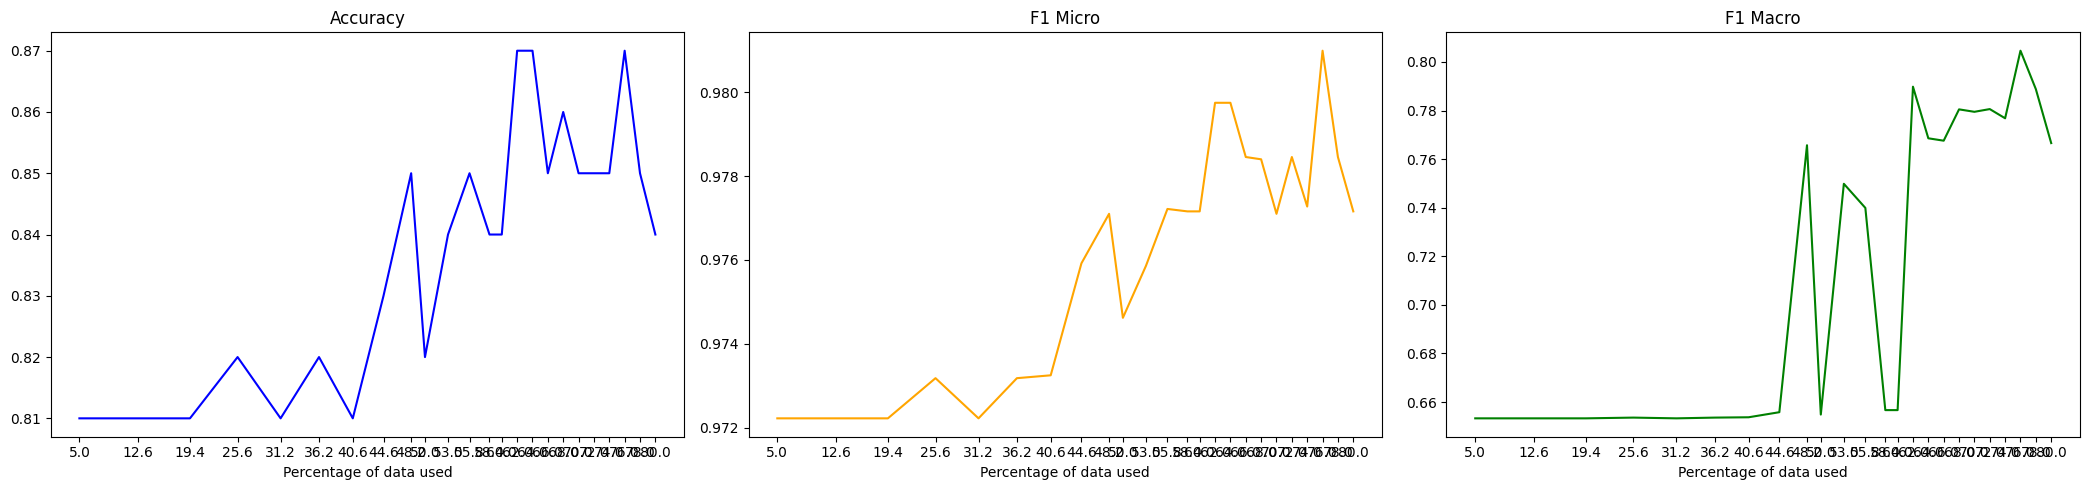

In [18]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.363988,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.269921,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.219893,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.200752,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.187067,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.179119,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.174042,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.171127,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.169264,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.168764,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.1841061115264893 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.264220,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.188312,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.164805,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.159173,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.152254,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.150134,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.149342,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.145715,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.145255,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.145182,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.9066948890686035 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.202796,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.161153,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.149283,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.143004,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.141167,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.138700,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.136817,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.137179,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.136752,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.136529,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.679966688156128 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.186913,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.156788,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.144550,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.140006,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.136499,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.135492,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.129525,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.126699,0.820000,0.964824,0.979592,0.972152,0.653148
9,No log,0.124681,0.830000,0.964912,0.982143,0.973451,0.719815
10,No log,0.123100,0.830000,0.964912,0.982143,0.973451,0.719815


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      0.99      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9734513274336283, F1 Macro: 0.7198146529750199
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      0.99      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.3976590633392334 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.176383,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.151265,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.140963,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136574,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.130861,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.125076,0.820000,0.964912,0.982143,0.973451,0.654117
7,No log,0.121862,0.840000,0.972152,0.979592,0.975858,0.655700
8,No log,0.118529,0.840000,0.974555,0.977041,0.975796,0.721260
9,No log,0.117001,0.830000,0.969697,0.979592,0.974619,0.703206
10,No log,0.116978,0.810000,0.967172,0.977041,0.972081,0.696260


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.84, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.300204277038574 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.167211,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143250,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138729,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.134500,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.124771,0.830000,0.965000,0.984694,0.974747,0.720784
6,No log,0.111344,0.840000,0.965087,0.987245,0.976040,0.750198
7,No log,0.111612,0.850000,0.967500,0.987245,0.977273,0.766811
8,No log,0.110538,0.840000,0.967419,0.984694,0.975980,0.755587
9,No log,0.112864,0.840000,0.962779,0.989796,0.976101,0.766811
10,No log,0.108075,0.850000,0.965174,0.989796,0.977330,0.776912


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.85, F1 Micro: 0.9773299748110832, F1 Macro: 0.7769123534969339
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.9819715023040771 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.162113,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139559,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.136688,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.130839,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.115997,0.830000,0.962687,0.987245,0.974811,0.749356
6,No log,0.117501,0.840000,0.960396,0.989796,0.974874,0.765951
7,No log,0.111761,0.850000,0.962779,0.989796,0.976101,0.776052
8,No log,0.117178,0.830000,0.960298,0.987245,0.973585,0.764970
9,No log,0.111501,0.820000,0.960199,0.984694,0.972292,0.763977
10,No log,0.112414,0.820000,0.960199,0.984694,0.972292,0.763977


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.96      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.9761006289308176, F1 Macro: 0.7760522559517535
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.96      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.793031930923462 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.156494,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138602,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.140386,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.120672,0.830000,0.960298,0.987245,0.973585,0.745749
5,No log,0.124133,0.810000,0.953431,0.992347,0.972500,0.744700
6,No log,0.109323,0.850000,0.965087,0.987245,0.976040,0.775930
7,No log,0.109144,0.830000,0.974490,0.974490,0.974490,0.774371
8,No log,0.106869,0.860000,0.974684,0.982143,0.978399,0.777463
9,No log,0.108453,0.870000,0.974747,0.984694,0.979695,0.778470
10,No log,0.108326,0.860000,0.972292,0.984694,0.978454,0.777572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7784698383693359
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.7489259243011475 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.161561,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136619,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131150,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.119478,0.820000,0.974425,0.971939,0.973180,0.719238
5,No log,0.109727,0.840000,0.962779,0.989796,0.976101,0.766071
6,No log,0.113515,0.820000,0.962594,0.984694,0.973518,0.757157
7,No log,0.105072,0.850000,0.974619,0.979592,0.977099,0.776444
8,No log,0.103133,0.840000,0.974555,0.977041,0.975796,0.775413
9,No log,0.105473,0.850000,0.972222,0.982143,0.977157,0.776565
10,No log,0.106181,0.840000,0.969773,0.982143,0.975919,0.775678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.95      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.85, F1 Micro: 0.9771573604060914, F1 Macro: 0.776565076464574
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.95      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 2.254103660583496 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155817,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135553,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123106,0.820000,0.962594,0.984694,0.973518,0.719951
4,No log,0.108727,0.830000,0.962594,0.984694,0.973518,0.728914
5,No log,0.105490,0.840000,0.962687,0.987245,0.974811,0.754840
6,No log,0.100123,0.840000,0.969773,0.982143,0.975919,0.775678
7,No log,0.110328,0.830000,0.964912,0.982143,0.973451,0.764699
8,No log,0.104922,0.850000,0.969773,0.982143,0.975919,0.775678
9,No log,0.104762,0.860000,0.974684,0.982143,0.978399,0.777463
10,No log,0.108956,0.840000,0.965000,0.984694,0.974747,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.95      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.86, F1 Micro: 0.9783989834815755, F1 Macro: 0.7774627228794618
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.95      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4396920204162598 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.157414,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.149976,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126301,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.112235,0.830000,0.960396,0.989796,0.974874,0.746720
5,No log,0.103703,0.800000,0.967089,0.974490,0.970775,0.751543
6,No log,0.101372,0.840000,0.965087,0.987245,0.976040,0.755700
7,No log,0.110342,0.840000,0.962687,0.987245,0.974811,0.765829
8,No log,0.104865,0.830000,0.967337,0.982143,0.974684,0.765577
9,No log,0.107178,0.840000,0.962687,0.987245,0.974811,0.765829
10,No log,0.105862,0.830000,0.967337,0.982143,0.974684,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.84, F1 Micro: 0.9760403530895334, F1 Macro: 0.7557002322848126
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.3507740497589111 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150093,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135436,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125599,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.108296,0.830000,0.974490,0.974490,0.974490,0.720255
5,No log,0.115461,0.810000,0.955665,0.989796,0.972431,0.732734
6,No log,0.115843,0.840000,0.962779,0.989796,0.976101,0.766811
7,No log,0.108397,0.850000,0.967500,0.987245,0.977273,0.767577
8,No log,0.103575,0.850000,0.967500,0.987245,0.977273,0.767577
9,No log,0.103116,0.850000,0.965087,0.987245,0.976040,0.775930
10,No log,0.102818,0.870000,0.972362,0.987245,0.979747,0.778567


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.87, F1 Micro: 0.979746835443038, F1 Macro: 0.7785666906695781
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.3270447254180908 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150307,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136124,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.140606,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.112541,0.840000,0.967337,0.982143,0.974684,0.710396
5,No log,0.105907,0.840000,0.962687,0.987245,0.974811,0.746609
6,No log,0.100490,0.840000,0.965000,0.984694,0.974747,0.754718
7,No log,0.105921,0.850000,0.965087,0.987245,0.976040,0.775930
8,No log,0.111510,0.840000,0.960396,0.989796,0.974874,0.765951
9,No log,0.103894,0.840000,0.965000,0.984694,0.974747,0.774937
10,No log,0.104529,0.840000,0.965000,0.984694,0.974747,0.774937


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.85, F1 Micro: 0.9760403530895334, F1 Macro: 0.7759301558296533
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.2353541851043701 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146390,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139929,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119312,0.820000,0.974425,0.971939,0.973180,0.719238
4,No log,0.103178,0.840000,0.965087,0.987245,0.976040,0.750198
5,No log,0.097829,0.820000,0.969620,0.977041,0.973316,0.773631
6,No log,0.096825,0.850000,0.969849,0.984694,0.977215,0.776683
7,No log,0.099399,0.860000,0.969925,0.987245,0.978508,0.777678
8,No log,0.102708,0.840000,0.974555,0.977041,0.975796,0.775413
9,No log,0.097360,0.860000,0.972292,0.984694,0.978454,0.777572
10,No log,0.097258,0.860000,0.972292,0.984694,0.978454,0.777572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9785082174462705, F1 Macro: 0.7776779710606146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.1680212020874023 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145330,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132710,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123141,0.820000,0.974425,0.971939,0.973180,0.701954
4,No log,0.102952,0.820000,0.967254,0.979592,0.973384,0.728667
5,No log,0.104497,0.840000,0.965087,0.987245,0.976040,0.766698
6,No log,0.105869,0.810000,0.974425,0.971939,0.973180,0.764120
7,No log,0.102564,0.860000,0.969925,0.987245,0.978508,0.777678
8,No log,0.106580,0.850000,0.967500,0.987245,0.977273,0.776799
9,No log,0.107138,0.850000,0.967500,0.987245,0.977273,0.767577
10,No log,0.105161,0.870000,0.974747,0.984694,0.979695,0.778470


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7784698383693359
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.082669734954834 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144211,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132674,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115971,0.850000,0.972152,0.979592,0.975858,0.655700
4,No log,0.107917,0.850000,0.977041,0.977041,0.977041,0.711915
5,No log,0.107324,0.830000,0.967337,0.982143,0.974684,0.765577
6,No log,0.102784,0.860000,0.969925,0.987245,0.978508,0.777678
7,No log,0.112284,0.840000,0.967419,0.984694,0.975980,0.766582
8,No log,0.102830,0.850000,0.972222,0.982143,0.977157,0.776565
9,No log,0.105141,0.850000,0.969849,0.984694,0.977215,0.776683
10,No log,0.105263,0.850000,0.969849,0.984694,0.977215,0.767471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.86, F1 Micro: 0.9785082174462705, F1 Macro: 0.7776779710606146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 1.068641185760498 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143446,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134544,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124729,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.097004,0.850000,0.977041,0.977041,0.977041,0.765577
5,No log,0.103561,0.840000,0.965087,0.987245,0.976040,0.766698
6,No log,0.092649,0.850000,0.974619,0.979592,0.977099,0.766464
7,No log,0.101755,0.860000,0.972292,0.984694,0.978454,0.777572
8,No log,0.094180,0.860000,0.974684,0.982143,0.978399,0.788686
9,No log,0.095102,0.870000,0.974747,0.984694,0.979695,0.789693
10,No log,0.095456,0.860000,0.972362,0.987245,0.979747,0.789799


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7897991831818266
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.9616518020629883 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142073,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130577,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.110142,0.830000,0.962687,0.987245,0.974811,0.749356
4,No log,0.097674,0.870000,0.974747,0.984694,0.979695,0.803619
5,No log,0.098955,0.860000,0.972362,0.987245,0.979747,0.781570
6,No log,0.097545,0.870000,0.977157,0.982143,0.979644,0.798328
7,No log,0.095282,0.850000,0.974619,0.979592,0.977099,0.776444
8,No log,0.099283,0.870000,0.977157,0.982143,0.979644,0.789584
9,No log,0.099611,0.850000,0.972222,0.982143,0.977157,0.767362
10,No log,0.099864,0.850000,0.972222,0.982143,0.977157,0.767362


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.781569886469384
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.9276604652404785 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148889,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135374,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117789,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.104384,0.840000,0.962871,0.992347,0.977387,0.767783
5,No log,0.093162,0.830000,0.974490,0.974490,0.974490,0.737668
6,No log,0.093208,0.830000,0.974490,0.974490,0.974490,0.737668
7,No log,0.098558,0.860000,0.969925,0.987245,0.978508,0.768466
8,No log,0.099107,0.860000,0.972292,0.984694,0.978454,0.768369
9,No log,0.103987,0.850000,0.969849,0.984694,0.977215,0.767471
10,No log,0.101032,0.850000,0.969849,0.984694,0.977215,0.767471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.86, F1 Micro: 0.9785082174462705, F1 Macro: 0.7684656805685678
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7895264625549316 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142890,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128658,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115910,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.109276,0.830000,0.960396,0.989796,0.974874,0.765951
5,No log,0.103837,0.860000,0.972292,0.984694,0.978454,0.768369
6,No log,0.096101,0.850000,0.972152,0.979592,0.975858,0.775547
7,No log,0.108485,0.850000,0.967419,0.984694,0.975980,0.775805
8,No log,0.100300,0.850000,0.969773,0.982143,0.975919,0.775678
9,No log,0.102959,0.860000,0.972222,0.982143,0.977157,0.776565
10,No log,0.105056,0.850000,0.969773,0.982143,0.975919,0.775678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.74      0.83      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7683688282683256
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.74      0.83      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6913125514984131 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142433,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131387,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.108941,0.820000,0.965000,0.984694,0.974747,0.729774
4,No log,0.100543,0.840000,0.965174,0.989796,0.977330,0.767681
5,No log,0.094314,0.850000,0.974619,0.979592,0.977099,0.787668
6,No log,0.106522,0.840000,0.965000,0.984694,0.974747,0.765704
7,No log,0.104364,0.850000,0.967419,0.984694,0.975980,0.766582
8,No log,0.106205,0.850000,0.967500,0.987245,0.977273,0.767577
9,No log,0.103450,0.840000,0.965000,0.984694,0.974747,0.766582
10,No log,0.102074,0.850000,0.967419,0.984694,0.975980,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.84, F1 Micro: 0.9773299748110832, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.577425479888916 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141795,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129295,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112823,0.800000,0.953317,0.989796,0.971214,0.731883
4,No log,0.109320,0.790000,0.962312,0.977041,0.969620,0.747657
5,No log,0.101591,0.860000,0.974684,0.982143,0.978399,0.777463
6,No log,0.097873,0.850000,0.972222,0.982143,0.977157,0.776565
7,No log,0.098828,0.850000,0.969925,0.987245,0.978508,0.777678
8,No log,0.107251,0.850000,0.972222,0.982143,0.977157,0.767362
9,No log,0.102318,0.860000,0.974684,0.982143,0.978399,0.777463
10,No log,0.103656,0.850000,0.972292,0.984694,0.978454,0.777572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7776779710606146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.5136406421661377 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140855,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137086,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.108334,0.850000,0.962871,0.992347,0.977387,0.777023
4,No log,0.096486,0.820000,0.969620,0.977041,0.973316,0.763683
5,No log,0.099140,0.850000,0.972222,0.982143,0.977157,0.776565
6,No log,0.107167,0.830000,0.962779,0.989796,0.976101,0.766811
7,No log,0.103652,0.830000,0.969697,0.979592,0.974619,0.757796
8,No log,0.105029,0.840000,0.967500,0.987245,0.977273,0.767577
9,No log,0.104486,0.830000,0.967419,0.984694,0.975980,0.758924
10,No log,0.101517,0.860000,0.972362,0.987245,0.979747,0.778567


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7785666906695781
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.5237529277801514 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142825,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.125909,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.109639,0.830000,0.965000,0.984694,0.974747,0.720784
4,No log,0.096785,0.830000,0.967419,0.984694,0.975980,0.730644
5,No log,0.103047,0.840000,0.965174,0.989796,0.977330,0.760013
6,No log,0.099437,0.840000,0.972152,0.979592,0.975858,0.766343
7,No log,0.101344,0.860000,0.970000,0.989796,0.979798,0.769450
8,No log,0.104794,0.830000,0.965087,0.987245,0.976040,0.759030
9,No log,0.098698,0.870000,0.972431,0.989796,0.981037,0.779551
10,0.098100,0.099710,0.870000,0.972431,0.989796,0.981037,0.779551


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7795506302366446
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 34.9 seconds
Total runtime: 2609.962256193161 seconds


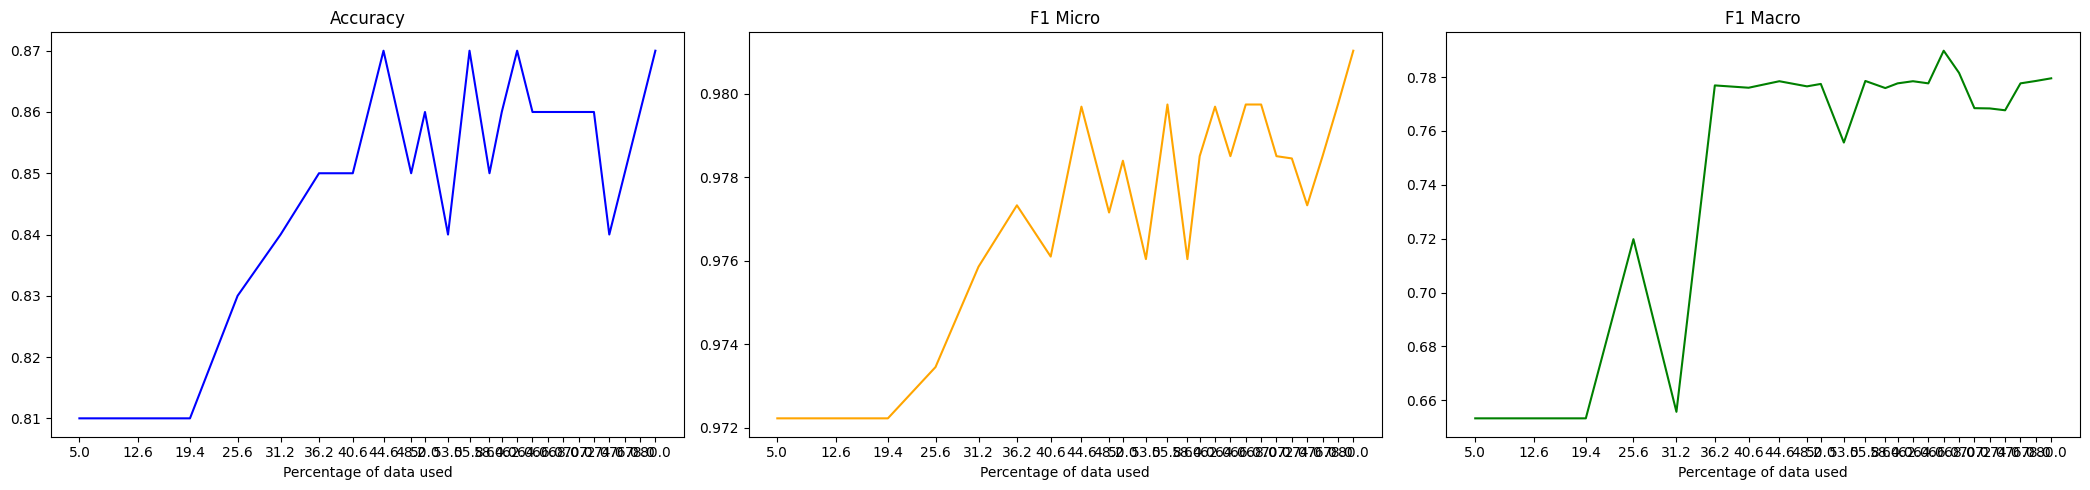

In [19]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.380765,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.275398,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.239973,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.220720,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.202465,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.190056,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.182793,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.178994,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.177267,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.177220,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.1236634254455566 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.283572,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.193354,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.164988,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.154339,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.150163,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.148043,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.144920,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.143170,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.142670,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.142630,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.838135004043579 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.209150,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.159037,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.145759,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.139013,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.134422,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.131719,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.128864,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.128914,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.125490,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.125663,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.6053216457366943 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.184668,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.149321,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.137460,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.131894,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.135177,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.126056,0.810000,0.964912,0.982143,0.973451,0.654117
7,No log,0.123996,0.820000,0.967337,0.982143,0.974684,0.654960
8,No log,0.124806,0.820000,0.967337,0.982143,0.974684,0.654960
9,No log,0.124206,0.810000,0.967254,0.979592,0.973384,0.653989
10,No log,0.123902,0.810000,0.969620,0.977041,0.973316,0.653859


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.82, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.376908540725708 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.167371,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140263,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135882,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.130269,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.126652,0.810000,0.964912,0.982143,0.973451,0.654117
6,No log,0.128366,0.820000,0.972010,0.974490,0.973248,0.653725
7,No log,0.124623,0.830000,0.972081,0.977041,0.974555,0.654718
8,No log,0.126927,0.830000,0.972081,0.977041,0.974555,0.654718
9,No log,0.127480,0.830000,0.972081,0.977041,0.974555,0.654718
10,No log,0.128184,0.830000,0.972081,0.977041,0.974555,0.654718


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.83, F1 Micro: 0.9745547073791349, F1 Macro: 0.6547180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.1739065647125244 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.161688,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138530,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131415,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.125320,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.123144,0.820000,0.967337,0.982143,0.974684,0.654960
6,No log,0.120616,0.830000,0.972152,0.979592,0.975858,0.655700
7,No log,0.119975,0.830000,0.972152,0.979592,0.975858,0.655700
8,No log,0.122872,0.830000,0.972081,0.977041,0.974555,0.654718
9,No log,0.121250,0.830000,0.972081,0.977041,0.974555,0.654718
10,No log,0.121647,0.830000,0.972081,0.977041,0.974555,0.654718


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 2.0467629432678223 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154693,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137330,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128602,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.121646,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.118258,0.820000,0.964912,0.982143,0.973451,0.654117
6,No log,0.118914,0.840000,0.972222,0.982143,0.977157,0.656672
7,No log,0.119746,0.840000,0.974619,0.979592,0.977099,0.656570
8,No log,0.118428,0.840000,0.974619,0.979592,0.977099,0.656570
9,No log,0.115049,0.840000,0.974619,0.979592,0.977099,0.656570
10,No log,0.114527,0.840000,0.974619,0.979592,0.977099,0.656570


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.8409509658813477 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154551,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134440,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125968,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.117664,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.113532,0.820000,0.974425,0.971939,0.973180,0.653588
6,No log,0.112745,0.830000,0.976923,0.971939,0.974425,0.654466
7,No log,0.111185,0.820000,0.974425,0.971939,0.973180,0.653588
8,No log,0.111735,0.820000,0.974425,0.971939,0.973180,0.653588
9,No log,0.110677,0.850000,0.974619,0.979592,0.977099,0.656570
10,No log,0.110710,0.820000,0.974425,0.971939,0.973180,0.653588


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.656569886469384
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.7537858486175537 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147266,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135159,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122326,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115762,0.840000,0.969773,0.982143,0.975919,0.655811
5,No log,0.115796,0.840000,0.979434,0.971939,0.975672,0.655353
6,No log,0.116211,0.840000,0.976982,0.974490,0.975734,0.655471
7,No log,0.114719,0.830000,0.976923,0.971939,0.974425,0.654466
8,No log,0.116118,0.850000,0.974684,0.982143,0.978399,0.657542
9,No log,0.113978,0.830000,0.974490,0.974490,0.974490,0.654593
10,No log,0.112894,0.820000,0.976864,0.969388,0.973111,0.653448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.6575418529109637
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.675689935684204 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144693,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133415,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121240,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115678,0.840000,0.972222,0.982143,0.977157,0.656672
5,No log,0.115507,0.850000,0.974619,0.979592,0.977099,0.656570
6,No log,0.110495,0.830000,0.976923,0.971939,0.974425,0.654466
7,No log,0.107618,0.850000,0.974619,0.979592,0.977099,0.765704
8,No log,0.105580,0.840000,0.974555,0.977041,0.975796,0.764699
9,No log,0.104010,0.850000,0.974619,0.979592,0.977099,0.765704
10,No log,0.104556,0.850000,0.974619,0.979592,0.977099,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.531592607498169 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145655,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129296,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118735,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.111379,0.840000,0.977041,0.977041,0.977041,0.656466
5,No log,0.111089,0.830000,0.976923,0.971939,0.974425,0.654466
6,No log,0.111875,0.840000,0.979434,0.971939,0.975672,0.655353
7,No log,0.111846,0.820000,0.976864,0.969388,0.973111,0.719086
8,No log,0.102069,0.850000,0.974619,0.979592,0.977099,0.765704
9,No log,0.101834,0.850000,0.974684,0.982143,0.978399,0.766698
10,No log,0.102951,0.860000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7666981711786742
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.4770681858062744 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145525,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134102,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.120377,0.820000,0.967254,0.979592,0.973384,0.653989
4,No log,0.112975,0.840000,0.972152,0.979592,0.975858,0.655700
5,No log,0.107659,0.840000,0.976982,0.974490,0.975734,0.655471
6,No log,0.103319,0.850000,0.977041,0.977041,0.977041,0.722138
7,No log,0.100723,0.860000,0.977099,0.979592,0.978344,0.797323
8,No log,0.105227,0.840000,0.972152,0.979592,0.975858,0.765577
9,No log,0.098879,0.860000,0.974684,0.982143,0.978399,0.797450
10,No log,0.101595,0.850000,0.972222,0.982143,0.977157,0.779593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.86, F1 Micro: 0.9783989834815755, F1 Macro: 0.7974503335296063
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.3777825832366943 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142847,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137256,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130625,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.114556,0.830000,0.974490,0.974490,0.974490,0.654593
5,No log,0.107882,0.840000,0.976982,0.974490,0.975734,0.655471
6,No log,0.103126,0.860000,0.977099,0.979592,0.978344,0.723133
7,No log,0.100340,0.860000,0.977099,0.979592,0.978344,0.766582
8,No log,0.100269,0.860000,0.977099,0.979592,0.978344,0.797323
9,No log,0.102043,0.870000,0.974747,0.984694,0.979695,0.798444
10,No log,0.101428,0.870000,0.974747,0.984694,0.979695,0.781466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.304053544998169 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140276,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128604,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.114157,0.840000,0.974619,0.979592,0.977099,0.656570
4,No log,0.115034,0.820000,0.976864,0.969388,0.973111,0.653448
5,No log,0.111042,0.840000,0.976982,0.974490,0.975734,0.655471
6,No log,0.106311,0.850000,0.977041,0.977041,0.977041,0.722138
7,No log,0.104030,0.850000,0.972222,0.982143,0.977157,0.779593
8,No log,0.104836,0.870000,0.974747,0.984694,0.979695,0.798444
9,No log,0.101899,0.840000,0.969773,0.982143,0.975919,0.765704
10,No log,0.101953,0.840000,0.969773,0.982143,0.975919,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.1834332942962646 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146716,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131808,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116892,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.109190,0.830000,0.976923,0.971939,0.974425,0.654466
5,No log,0.115994,0.860000,0.972292,0.984694,0.978454,0.767577
6,No log,0.108767,0.840000,0.965087,0.987245,0.976040,0.759030
7,No log,0.103077,0.870000,0.974747,0.984694,0.979695,0.781466
8,No log,0.099894,0.870000,0.974747,0.984694,0.979695,0.781466
9,No log,0.102136,0.840000,0.969773,0.982143,0.975919,0.755471
10,No log,0.100411,0.860000,0.972292,0.984694,0.978454,0.767577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.134153127670288 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145934,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128122,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118633,0.840000,0.979434,0.971939,0.975672,0.655353
4,No log,0.105284,0.840000,0.974555,0.977041,0.975796,0.655587
5,No log,0.110116,0.830000,0.965087,0.987245,0.976040,0.759030
6,No log,0.099916,0.880000,0.974811,0.987245,0.980989,0.799427
7,No log,0.099199,0.850000,0.969849,0.984694,0.977215,0.766698
8,No log,0.100527,0.840000,0.967419,0.984694,0.975980,0.765829
9,No log,0.100512,0.860000,0.969925,0.987245,0.978508,0.780700
10,No log,0.098536,0.850000,0.969849,0.984694,0.977215,0.779718


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.88, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 1.0023901462554932 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140574,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132229,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118813,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.110225,0.830000,0.976923,0.971939,0.974425,0.654466
5,No log,0.110845,0.800000,0.976744,0.964286,0.970475,0.651378
6,No log,0.105201,0.830000,0.976923,0.971939,0.974425,0.794235
7,No log,0.109326,0.860000,0.974684,0.982143,0.978399,0.780471
8,No log,0.109166,0.840000,0.969773,0.982143,0.975919,0.755471
9,No log,0.106050,0.870000,0.977157,0.982143,0.979644,0.798328
10,No log,0.106454,0.870000,0.977215,0.984694,0.980940,0.799323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.87, F1 Micro: 0.9809402795425667, F1 Macro: 0.7993229927056363
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.9878251552581787 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138967,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.123938,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119884,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.108235,0.830000,0.976982,0.974490,0.975734,0.655471
5,No log,0.103660,0.840000,0.974555,0.977041,0.975796,0.711027
6,No log,0.104225,0.830000,0.969697,0.979592,0.974619,0.754466
7,No log,0.098909,0.870000,0.974811,0.987245,0.980989,0.782449
8,No log,0.100126,0.850000,0.972292,0.984694,0.978454,0.767577
9,No log,0.101269,0.850000,0.972292,0.984694,0.978454,0.767577
10,No log,0.098820,0.850000,0.972292,0.984694,0.978454,0.767577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7824492574604868
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.975905179977417 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140265,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131335,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112765,0.830000,0.974555,0.977041,0.975796,0.655587
4,No log,0.104414,0.830000,0.976923,0.971939,0.974425,0.654466
5,No log,0.105552,0.820000,0.972010,0.974490,0.973248,0.736782
6,No log,0.101632,0.830000,0.974490,0.974490,0.974490,0.748686
7,No log,0.106382,0.820000,0.969620,0.977041,0.973316,0.753448
8,No log,0.107667,0.840000,0.967500,0.987245,0.977273,0.748358
9,No log,0.105110,0.840000,0.967500,0.987245,0.977273,0.748358
10,No log,0.102686,0.840000,0.967500,0.987245,0.977273,0.748358


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.43      0.75      0.55         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.72      0.79      0.75       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.84, F1 Micro: 0.9772727272727273, F1 Macro: 0.7483583483695777
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.43      0.75      0.55         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.72      0.79      0.75       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.8013856410980225 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140469,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.123318,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113377,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.115653,0.790000,0.967005,0.971939,0.969466,0.742287
5,No log,0.106982,0.840000,0.972222,0.982143,0.977157,0.722367
6,No log,0.106745,0.840000,0.965174,0.989796,0.977330,0.767681
7,No log,0.106324,0.810000,0.969543,0.974490,0.972010,0.744214
8,No log,0.102268,0.850000,0.969849,0.984694,0.977215,0.756466
9,No log,0.103982,0.840000,0.967419,0.984694,0.975980,0.747375
10,No log,0.104969,0.840000,0.965087,0.987245,0.976040,0.759030


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.84, F1 Micro: 0.9773299748110832, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6984343528747559 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138268,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131056,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117360,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.103202,0.830000,0.969773,0.982143,0.975919,0.704189
5,No log,0.098429,0.840000,0.969849,0.984694,0.977215,0.731523
6,No log,0.099193,0.840000,0.967419,0.984694,0.975980,0.766582
7,No log,0.105721,0.850000,0.967581,0.989796,0.978562,0.768560
8,No log,0.102446,0.850000,0.967581,0.989796,0.978562,0.768560
9,No log,0.100344,0.850000,0.967581,0.989796,0.978562,0.768560
10,No log,0.100534,0.850000,0.967581,0.989796,0.978562,0.768560


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5938248634338379 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139006,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135927,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111544,0.830000,0.976923,0.971939,0.974425,0.654466
4,No log,0.105680,0.830000,0.969697,0.979592,0.974619,0.723026
5,No log,0.099759,0.850000,0.969925,0.987245,0.978508,0.740875
6,No log,0.106129,0.830000,0.965000,0.984694,0.974747,0.758035
7,No log,0.095300,0.840000,0.967419,0.984694,0.975980,0.766582
8,No log,0.100613,0.860000,0.970000,0.989796,0.979798,0.769450
9,No log,0.096976,0.860000,0.970000,0.989796,0.979798,0.769450
10,No log,0.098506,0.860000,0.970000,0.989796,0.979798,0.769450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.86, F1 Micro: 0.9797979797979798, F1 Macro: 0.7694496201356343
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.4877963066101074 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141575,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.120425,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.107406,0.830000,0.974555,0.977041,0.975796,0.655587
4,No log,0.121746,0.790000,0.976744,0.964286,0.970475,0.742682
5,No log,0.100099,0.850000,0.969925,0.987245,0.978508,0.757449
6,No log,0.095576,0.830000,0.972081,0.977041,0.974555,0.764559
7,No log,0.096818,0.850000,0.969925,0.987245,0.978508,0.757449
8,No log,0.099168,0.840000,0.969849,0.984694,0.977215,0.756466
9,No log,0.102509,0.840000,0.967500,0.987245,0.977273,0.767577
10,No log,0.098587,0.840000,0.969849,0.984694,0.977215,0.756466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7574492574604869
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.5221438407897949 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143916,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.122371,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.110511,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.098259,0.840000,0.969849,0.984694,0.977215,0.739903
5,No log,0.104862,0.840000,0.965087,0.987245,0.976040,0.759030
6,No log,0.101510,0.850000,0.967500,0.987245,0.977273,0.767577
7,No log,0.112541,0.830000,0.960396,0.989796,0.974874,0.758264
8,No log,0.106940,0.840000,0.965087,0.987245,0.976040,0.759030
9,No log,0.102171,0.830000,0.967337,0.982143,0.974684,0.765577
10,0.100300,0.104702,0.830000,0.967337,0.982143,0.974684,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.9772727272727273, F1 Macro: 0.7675769609596045
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 34.51 seconds
Total runtime: 2596.9711945056915 seconds


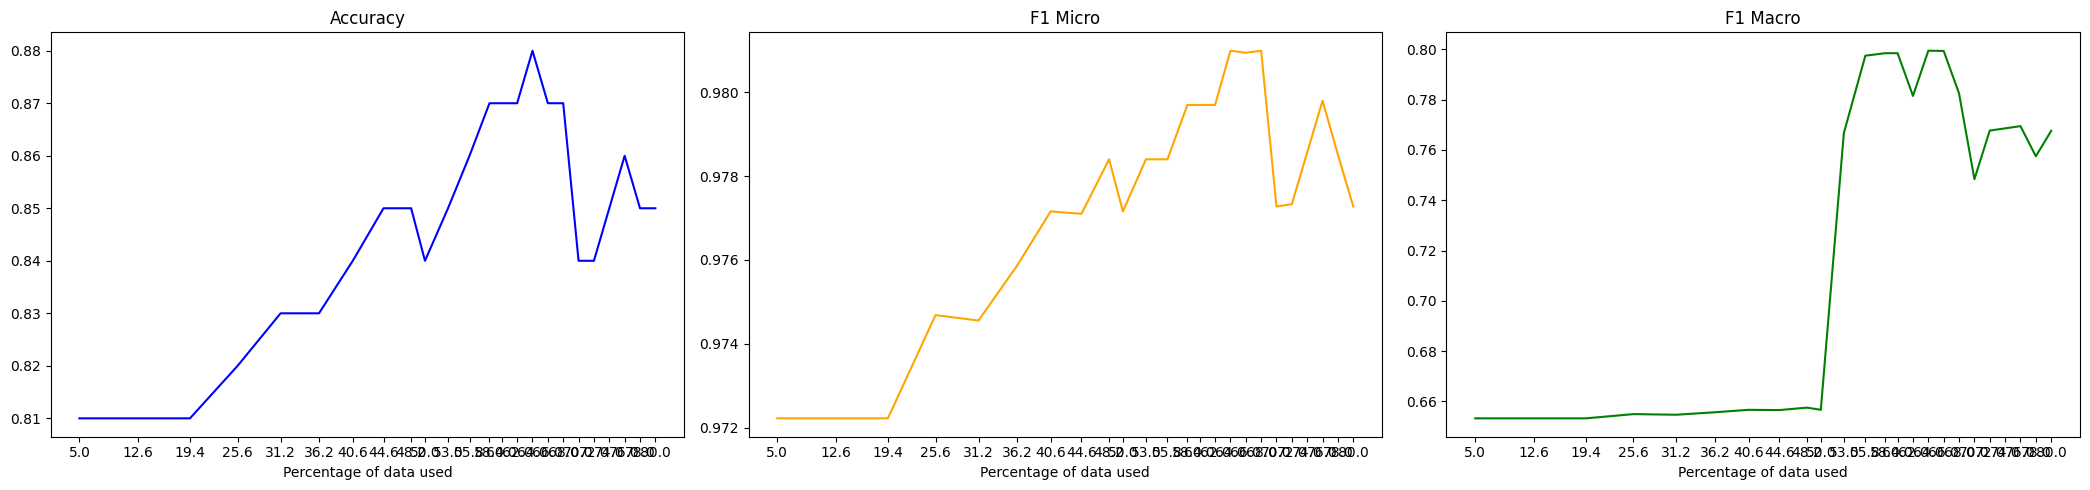

In [20]:
active_learning(seeds[4], 4)